In [1]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import numpy as np
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import pyaudio
import wave
 
import numpy, scipy, matplotlib.pyplot as plt
import librosa, librosa.display 
 

## Creating the training Dataframe

In [2]:
chords=['c','c#','d','d#','e','f','f#','g','g#','a','a#','b','cm','c#m','dm','d#m','em','fm','f#m','gm','g#m','am','a#m','bm']
notes=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
starthop=512
A=[]
for i in range(len(chords)):
    with open("guitar_clean_"+str(starthop)+"/"+chords[i]+".json") as readfile :
        a = readfile.read()
    a = a.strip()
    x = json.loads(a)
    for j in range(len(x)):
        sum=0
        for su in range(12):
            sum=sum+x[j][su]
        if sum > 1:
            x[j].append(i)
            A.append(x[j])
        
for i in range(len(chords)):
    with open("guitar_"+str(starthop)+"/"+chords[i]+".json") as readfile :
        a = readfile.read()
    a = a.strip()
    x = json.loads(a)
    for j in range(len(x)):
        sum=0
        for su in range(12):
            sum=sum+x[j][su]
        if sum > 1:
            x[j].append(i)
            A.append(x[j])

print(len(A))
df = pd.DataFrame(A)
df.columns = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','Label']
print("done")

26758
done


## Training the Classifier

In [3]:
# Split dataset in training and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.25, random_state=int(time.time()))

model = GaussianNB()
used_features = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
# Train classifier
model.fit(
    X_train[used_features].values,
    X_train["Label"]
)
model_pred = model.predict(X_test[used_features])


print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%" .format(X_test.shape[0],(X_test["Label"] != model_pred).sum(),100*(1-(X_test["Label"] != model_pred).sum()/X_test.shape[0])))



Number of mislabeled points out of a total 6690 points : 2134, performance 68.10%


In [4]:
#the Classifier
gnb = GaussianNB()
used_features = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
# Training the classifier
gnb.fit(df[used_features].values,df["Label"])



GaussianNB(priors=None)

## For single instance Static Chord Recognition

In [5]:
FORMAT = pyaudio.paInt16
RATE = 44100
BUFF = 1024
Duration = 10
out = "file.wav"
 
audio = pyaudio.PyAudio()
stream = audio.open(format=FORMAT, channels=2, rate=RATE, input=True, frames_per_buffer=BUFF)

# for it in range(0,20):
print ("recording...")
frames = []
for i in range(0, int(RATE / BUFF * Duration)):
    data = stream.read(BUFF)
    frames.append(data)
print ("finished recording")

# stop Recording

waveFile = wave.open(out, 'wb')
waveFile.setnchannels(2)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()



recording...
finished recording


In [6]:

x, sr = librosa.load('file.wav')
test = librosa.feature.chroma_stft(x, sr=sr, hop_length=128)
list2=[]
for j in range(len(test[0])):
    a=[]
    for k in range(12):
        a.append(test[k][j])
    list2.append(a)

df2 = pd.DataFrame(list2)

df2.columns = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
y_pred = gnb.predict(list2)

acc={}
for cho in range(len(chords)):
    count = 0
    for y in y_pred:
        if y == cho : 
            count = count + 1
    acc[chords[cho]]=count/len(y_pred)

import operator

s=max(acc.items(), key=operator.itemgetter(1))[0]
i=chords.index(s)
mid=(i+4)%12
cname=notes[i%12]
if i > 11:
    mid=(3+i)%12
    cname=cname+"-Minor"
else:
    cname=cname+"-Major"

print (cname,"with a match of ",acc[s]*100,"%")     


A-Minor with a match of  100.0 %


/home/shivangi/anaconda3/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


## Dynamic Chord Detection

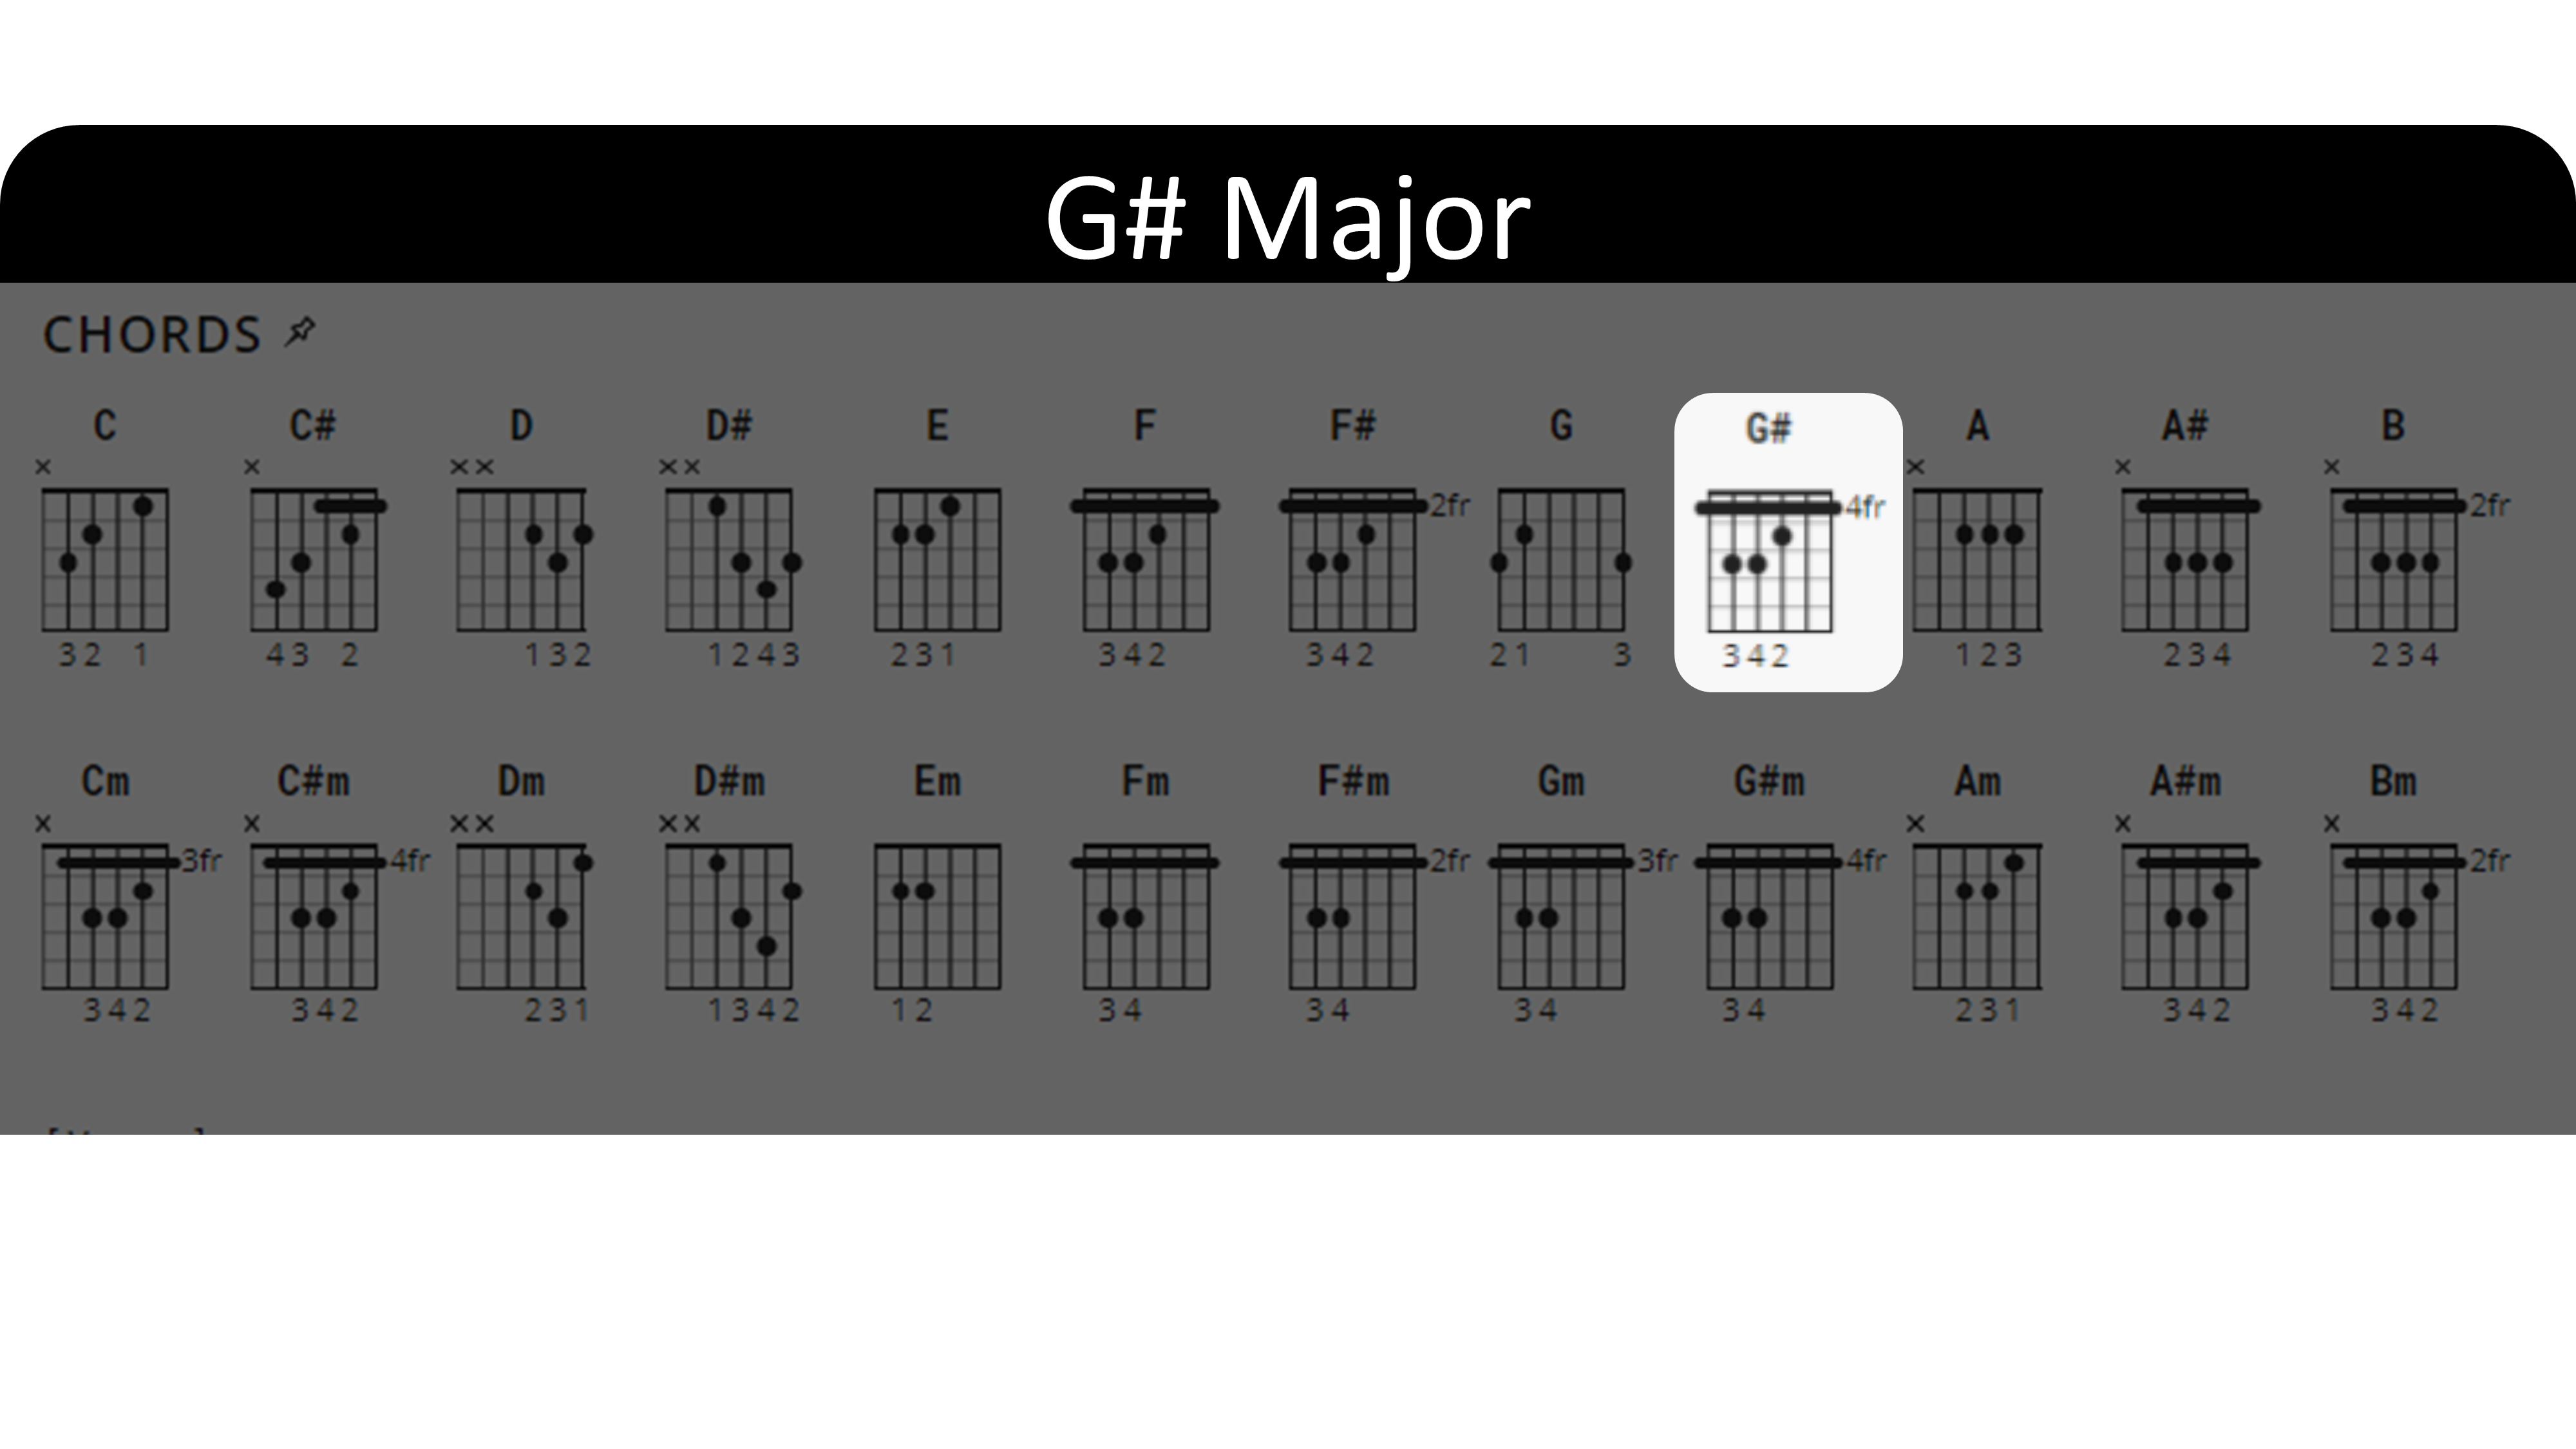

KeyboardInterrupt: 

In [11]:
import warnings
from IPython.display import Image, display, clear_output
import time

warnings.filterwarnings("ignore")

FORMAT = pyaudio.paInt16
RATE = 44100
BUF = 1024
duration = 2
out = "file.wav"

audio = pyaudio.PyAudio()
stream = audio.open(format=FORMAT, channels=2, rate=RATE, input=True, frames_per_buffer=BUF)
old=-1

full=[]
chordsdet=[]
print("Identifying Chords")
for it in range(0,50):
    frames = []
    for i in range(0, int(RATE / BUF * duration)):
        data = stream.read(BUF)
        frames.append(data)
        full.append(data)


    # stop Recording
    waveFile = wave.open(out, 'wb')
    waveFile.setnchannels(2)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()


    x, sr = librosa.load(out)
    test = librosa.feature.chroma_stft(x, sr=sr, hop_length=128)
    list2=[]
    for j in range(len(test[0])):
        a=[]
        for k in range(12):
            a.append(test[k][j])
        list2.append(a)

    df2 = pd.DataFrame(list2)
    df2.columns = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    y_pred = gnb.predict(list2)

    acc={}
    for cho in range(len(chords)):
        count = 0
        for y in y_pred:
            if y == cho : 
                count = count + 1
        acc[chords[cho]]=count/len(y_pred)

    import operator

    s=max(acc.items(), key=operator.itemgetter(1))[0]
    i=chords.index(s)
    mid=(i+4)%12
    cname=notes[i%12]
    if i > 11 :
        mid=(3+i)%12
        cname=cname+" Minor"
    else:
        cname=cname+" Major"
    if old != i:
        clear_output(wait=True)
        display(Image(filename="chords/Slide"+str(i+1)+".PNG"))
        #print (cname)
#         Image(filename='output_1_'+str(i)+'.png')
        chordsdet.append(cname)
    old=i
print("Stopped")

stream.stop_stream()
stream.close()
audio.terminate()
print (chordsdet)
waveFile = wave.open(out, 'wb')
waveFile.setnchannels(2)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(full))
waveFile.close()

In [ ]:
print(chordsdet)